In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Read this First

#### Remember that `tab` is is useful for autocompletion.

#### Remember that `shift + tab` is useful for rapidly obtaining usage + documentation.

###**Corner Detection**

**Over the past couple of weeks we've seen how we're able to do certain things with single images, such as binary image processing, and edge detection. This is all good when we want to manipulate a single image, but what happens if we want to find matches between two images? We need features to do so, and corner detection is a very useful tool that can be used to find corners, which is a very useful feature.**

**In this notebook we'll run through the Harris corner detector to see how we can find corners in the image in order to use as image features.**

**Let's first load an image to do corner detection with. Notice that we scale the grayscale image so that when we multiply derivatives the values don't explode.**

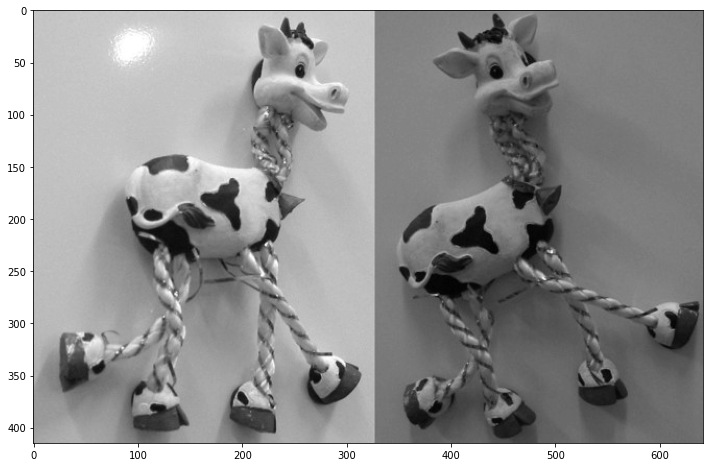

In [2]:
import cv2
color_image = cv2.imread('corner_detection.jpg', cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY) / 255.0
rows, cols = gray_image.shape
plt.figure(figsize=(12,8))
plt.imshow(gray_image, cmap='gray')

**In the lecture, we saw that to find corners, a patch containing corners has to have strong edge response in multiple directions. Using scipy's gaussian filter, apply a derivative of gaussian filter with a sigma of 3 to get i_x, the gradient response in the x direction, and i_y, the gradient response in the y direction. Display both results below.**

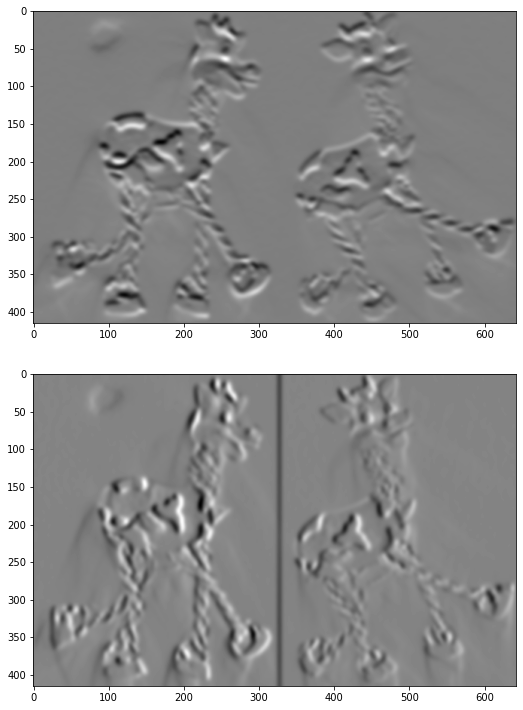

In [3]:
from scipy.ndimage.filters import gaussian_filter

i_x = gaussian_filter(gray_image, 3, (1, 0))
i_y = gaussian_filter(gray_image, 3, (0, 1))

fig, axs = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=3.0)

axs[0].imshow(i_x, cmap='gray')
axs[1].imshow(i_y, cmap='gray')

**Recall that previously for edge detection we then took the gradients in the x and y direction and computed the magnitude. This is nice, but it's not really useful since the magnitude is a scalar number. Corners require us to have strong edges in multiple directions, so condensing the gradient information into a single number causes us to lose the directionality of the response, making us unable to tell if it is a corner.**

**Hence in class we saw that we can find these responses by considering how a patch of an image changes in intensity as we move it around. After some derivation with Taylor series approximation, we see that the change is dependent on the local gradients, which form the H matrix.**

**First, using i_x and i_y, compute $I^2_x$, $I_xI_y$, and $I_y^2$. Also show that $I_xI_y=I_yI_x$**

In [4]:
i_x2 = i_x ** 2
i_xy = i_x * i_y
i_y2 = i_y ** 2

diff = i_x * i_y - i_y * i_x
print(abs(diff).sum())

0.0


We see that the summ of the absolute values of $(I_xI_y - I_yI_X)$ are 0, so all elements of $I_xI_y$ are the same as all elements of $I_yI_x$. This is because we are doing a element wise multiplication, not a matrix multiplication. Using commutativity, we can easily see that for all i, j $\in I$:

> $$I_x[i, j] I_y[i, j] = I_y[i, j] I_x[i, j]$$


**Now that we have $I^2_x$, $I_xI_y$, and $I^2_y$, can we directly form the H matrix at every pixel based on those values? No! Recall that to find corners, we have to consider a small local area. Hence at each pixel (i, j), we have to sum up the $I^2_x$, $I_xI_y$, and $I^2_y$ values in the neighbouring pixels to get the H matrix for our current pixel.**

**For every pixel in the image, compute the H matrix based on a neighbourhood of 7x7. That is, for every pixel, compute the sum of $I^2_x$, the sum of $I_xI_y$, and the sum of $I_y^2$ of itself and its neighbours within the 7x7 region centered about that pixel.**

**You don't have to explicitly create a matrix for every pixel - just save it in three 2D arrays in the same shape as the image, with the first storing the $I^2_x$ values, the second storing the $I_xI_y$ values, and the third storing the $I^2_y$ values.**

In [5]:
from scipy.signal import convolve2d

ker = np.ones((7, 7))

i_x2_sum = convolve2d(i_x2, ker, mode='same')
i_xy_sum = convolve2d(i_xy, ker, mode='same')
i_y2_sum = convolve2d(i_y2, ker, mode='same')

**Though a square neighbourhood area works, one of the largest issues is that this weighs the contribution of the neighbouring pixels equally. For pixel $(i, j)$, pixels far from $(i, j)$ have the same impact as pixels closer to $(i, j)$, as long as they are all in the neighbourhood. This isn't a great assumption, so we often want to weigh the pixels in the neighbourhood so that the pixels closer to $(i, j)$ count more.**

**A gaussian distribution centered about our pixel $(i, j)$ does exactly this!**

**For every pixel in the image, compute the H matrix based on a gaussian neighbourhood of sigma=3. That is, for every pixel, compute the sum of $I^2_x$, the sum of $I_xI_y$, and the sum of $I_y^2$ of itself and its neighbours, with the values of each neighbouring pixel weighted by a gaussian distribution with sigma=3.**

**(If you used a for loop to do the previous question, you're probably going to have a hard time doing this with the same method - think convolutions!)**

In [6]:
t = 7/3
s = 3

i_x2_sum = gaussian_filter(i_x2, s, mode='constant', truncate=t)
i_xy_sum = gaussian_filter(i_xy, s, mode='constant', truncate=t)
i_y2_sum = gaussian_filter(i_y2, s, mode='constant', truncate=t)

**Now that we have the contents of the H matrix for every pixel computed, we can then move to the next step - which we saw was computing the eigenvalues of the matrix.**

**Using the equation in the slides, write a function that computes the eigenvalues of a 2x2 matrix.**

In [7]:
def find_eigenvalues(h11, h12, h21, h22):
    """ Computes the eigenvalues of the H matrix
        H = [[h11 h12],
             [h21 h22]]
        Args: 
            h11: The value in top left of the matrix
            h12: The value in top right of the matrix
            h21: The value in bottom left of the matrix
            h22: The value in bottom right of the matrix
        Returns:
            lambda_1: The first eigenvalue of the matrix
            lambda_2: The second eigenvalue of the matrix
    """

    lambda_1 = 0.5 * (h11 + h22 + np.sqrt(4*h12*h21 + (h11 - h22)**2))
    lambda_2 = 0.5 * (h11 + h22 - np.sqrt(4*h12*h21 + (h11 - h22)**2))

    return lambda_1, lambda_2

**Now that we have a method of computing the eigenvalues of the H matrix at each pixel, we need to find the Harris corner response at each pixel. For every pixel, compute the harris corner response using the H matrix and the eigenvalues. Save those values in h_responses, and plot it**


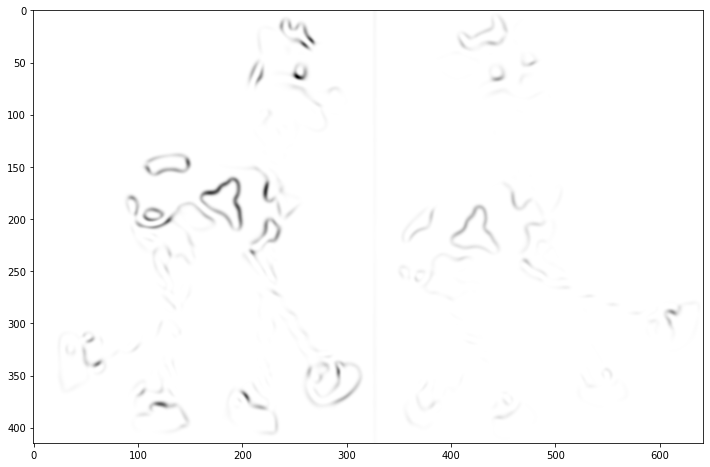

In [8]:
h_responses = np.zeros((rows, cols), dtype=np.float64)
k = .04

def harris_response_pix(a, b, c):
  h1, h2 = find_eigenvalues(a, b, b, c)
  return h1 * h2 - k*(h1 + h2) ** 2


for i in range(rows):
  for j in range(cols):
    h_responses[i,j] = harris_response_pix(i_x2[i,j], i_xy[i, j], i_y2[i,j])

plt.figure(figsize=(12,8))
plt.imshow(h_responses, cmap='gray')

**We then want the maximal responses, so we should threshold and perform non-maximum suppression. These are implemented for you.**

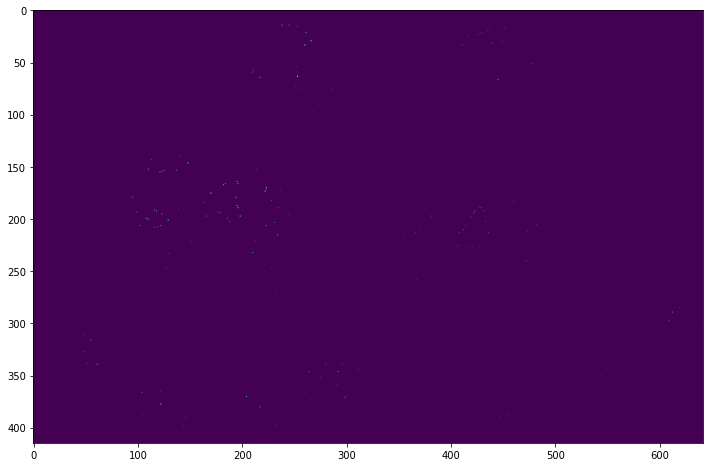

In [9]:
from scipy.ndimage.filters import maximum_filter

threshold = 0.08
h_responses = h_responses / np.max(h_responses)
h_responses[h_responses < threshold] = 0

suppressed = np.copy(h_responses)
filtered = maximum_filter(suppressed, (3, 3))
maxima = (suppressed == filtered)
suppressed[np.logical_not(maxima)] = 0

plt.figure(figsize=(12, 8))
plt.imshow(suppressed)

**Finally, we have points of maximum that correspond to the corners. Using those maxima, plot a small red circle onto the original color_image at those locations. Display the result (Make sure to display in RGB so it looks nice).**

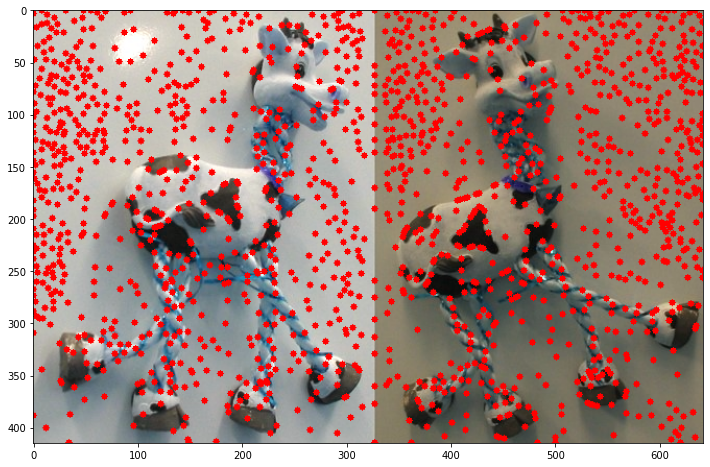

In [10]:
cpy_img = color_image.copy()

for i in range(rows):
  for j in range(cols):
    if suppressed[i,j] > 0:
      cv2.circle(cpy_img, (j, i), 3, (255, 0, 0), thickness=-1)

plt.figure(figsize=(12, 8))
plt.imshow(cpy_img)

**Notice how the the red dots are were the corners end to be, and the red dots that exist in both images tend to be in the same locations - which goes to show that corners are nice features.**

**Also see that there are a lot of different parameters, such as the $k$ when computing the harris corner response, the size of the gaussian window when computing the H matrix, and also the threshold near the end. Feel free to play around with those and note down the observations that you see.**

Increasing the threshold and k value decreas the number of detected points. Increasing the filter size increases the number of detected points.

###**Blob Detection**

**We saw just now that we were able to detect corners in images to serve as features. However, we saw in lecture that even though corner response is invariant with respect to rotation, it is not invariant to scaling. Blob detection on the other hand, is invariant to orientation and size!**

**For this portion, I'll walk you through the beginnings of blob detection, but we won't be implementing an entire blob detection algorithm, since there's a few details that are out of the scope for this class.**

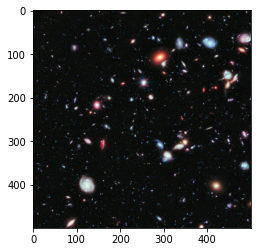

In [11]:
from skimage import data
from scipy import ndimage

color_image = data.hubble_deep_field()[0:500, 0:500]
image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY) / 255.0  
plt.imshow(color_image)

**We want to be able to detect the blobs (galaxies in the image) using blob detection. We saw that we could do this by convolving the image with a normalized laplacian of gaussian of different sizes. Because this is slow, we saw in lecture that we could approximate this using a difference of gaussians.**

**Let's try this out in 1D first. Plot the original_signal shown here below.**

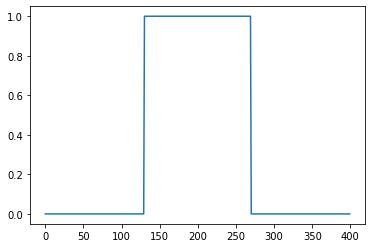

In [12]:
original_signal = np.zeros(400)
original_signal[130:270] = 1

plt.plot(original_signal)

**Now we want to filter by the laplacian to find the presence of the blob in the original signal. Using ndimage.gaussian_laplace, convolve our original signal with the laplacian with a sigma=3. Plot the result.**

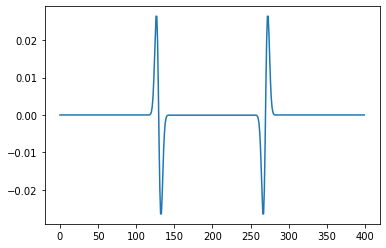

In [13]:
resp = ndimage.gaussian_laplace(original_signal, 3)

plt.plot(resp)

**Now try convolving with a laplacian of sigma=10, and another with sigma=30, and plot them both separately.**

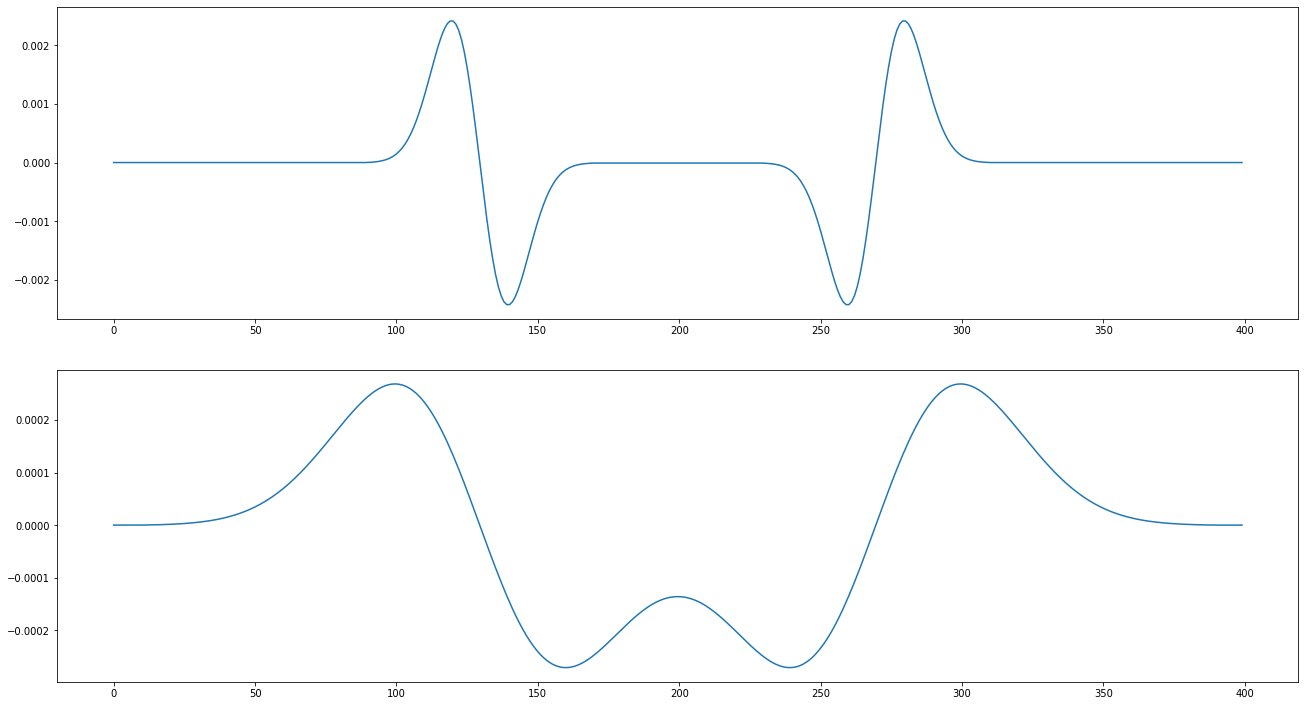

In [14]:
resp_10 = ndimage.gaussian_laplace(original_signal, 10)
resp_30 = ndimage.gaussian_laplace(original_signal, 30)


fig, axs = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=3.0)

axs[0].plot(resp_10)
axs[1].plot(resp_30)

**We observe the sigma=30 response is more similar to what we are looking for, where there is a single extrema. However, notice the y-axis scale values! What happens as we increase sigma?**

As we increase sigma, the curve becomes smoother, but the absolute value of the convolved signal decreases.

**Because the larger gaussians produce a great smoothing component (hence decreasing the blob magnitude), we want to normalize this by multiplying the response by $\sigma^2$. Do this below, by convolving our original signal with a laplacian of size $\sigma=20$ and multiplying this response by $\sigma^2$.**

In [15]:
s = 60

imin = 0
rmin = (ndimage.gaussian_laplace(original_signal, imin) * imin ** 2).min()

for i in range(100):
  resp = ndimage.gaussian_laplace(original_signal, i) * i ** 2

  if resp.min() < rmin:
    rmin = resp.min()
    imin = i

print(imin)

70


**Change the value of sigma to see at which sigma we have the maximal response. Why do we expect it to be this sigma?**

The maximum response occurs at $\sigma = 70$ which is half the size of the blob

**We can also use the difference of gaussians (DoG) as an approximation of normalized laplacian of gaussians (NLoG). Let's show this.** 

**Convolve the original_signal using a gaussian of sigma=10 and a gaussian of sigma=15. Also convolve the original_signal using a laplacian of size sigma=10**

**Plot the difference between the gaussians. On the same graph, plot the laplacian response, scaled by multiplying by 40.**

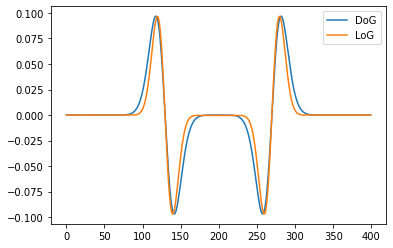

In [16]:
r1 = gaussian_filter(original_signal, 15) - gaussian_filter(original_signal, 10)
r2 = ndimage.gaussian_laplace(original_signal, 10) * 40

plt.plot(r1, label="DoG")
plt.plot(r2, label="LoG")
plt.legend()

**Is this what you expected?**

The plots are very similar, since the DoG is an approximation of the LoG up to a constant scaling.

**Now, let's try and do the same thing in 2D**

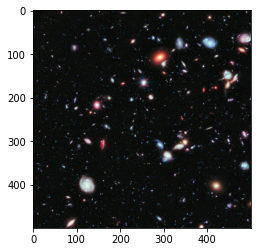

In [17]:
color_image = data.hubble_deep_field()[0:500, 0:500]
image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY) / 255.0  
plt.imshow(color_image)

**We have the image, and we have a set range of $k$'s and $s$'s. We first want to compute the difference of gaussians given our $k$ and $s$ parameters. Do this by setting glo to be the response after filtering with a gaussian of $\sigma=k^i$, and setting ghi as the response after filtering with a gaussian of $\sigma=k^{i+1}$. Then, save the difference between glo and ghi in dogs.**

In [18]:
# Finds the dimensions of the image
rows, cols = image.shape

# Hyperparameters
k = 2 ** (0.2)      # Difference between the sigmas of the different gaussian levels
s = 28              # Number of levels

# Create containers for the difference of gaussians (dogs) and the gradient of those (gods)
dogs = np.zeros((rows, cols, s))
sigmas = np.zeros((1, s))

# Loops through every level to create a gaussian filtered image at each level
for i in range(s):

    # Performs gaussian filtering
    glo = gaussian_filter(image, k**i)
    ghi = gaussian_filter(image, k**(i + 1))

    # Saves the difference and the corresponding sigma simulateneously
    dogs[:, :, i] = ghi - glo
    sigmas[0, i] = k ** i


**Once we have a response for a wide range of DoGs, we then have to find the local extrema in order to find points of interest (where there is a good response to the NLoG, which suggests a blob of that size is in the image.**

**Compare each point in dogs with its 3x3x3 grid, and save the $(i, j, k)$ coordinates as a tuple into pois if it is the local minimum or maximum.** 

In [19]:
# Finds the initial points of interest by taking local maxima and minima
# Compares each point with its 3x3x3 grid and saves it if it the local maximum or minimum
pois = []

import scipy

min = scipy.ndimage.minimum_filter(dogs, size = 5)
max = scipy.ndimage.maximum_filter(dogs, size = 5)

for i in range(rows):
  for j in range(cols):
    for k in range(s):
      if dogs[i,j,k] == min[i,j,k] or dogs[i,j,k] == max[i,j,k]:
        pois.append((i,j,k))

**We can then plot some circles on the original image to see what our blob response yields.**

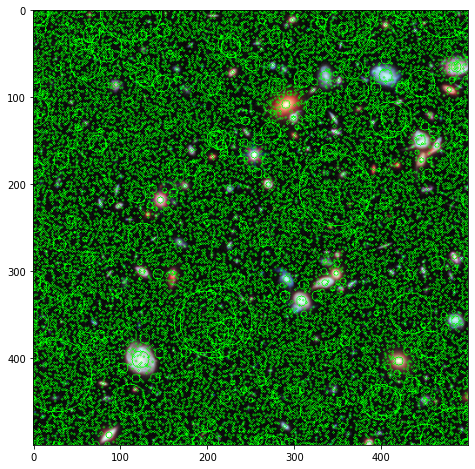

In [20]:
testim = color_image.copy()
for i in range(len(pois)):
  cv2.circle(testim, (pois[i][1], pois[i][0]), radius=int(sigmas[0, pois[i][2]]), color=(0, 255, 0), thickness=1)
plt.figure(figsize=(12, 8))
plt.imshow(testim)

**Though we see that a lot of the galaxies have green circles bounding them that seems like about the right size, there's a lot of responses. We need to do some post-processing to remove the weaker points in the image.**

**Below is some code I wrote a while ago to do some filtering - I'm don't recall what it really does anymore or why I did this, and it works okay. Just run it and hopefully it works.**

In [21]:
# We then have to remove weak points
refined_pois = []
for i in range(len(pois)):
    y = pois[i][0]
    x = pois[i][1]
    sig = pois[i][2]

    # We find the derivatives and double derivatives in both directions and across sigma
    try:
      dx = dogs[y, x + 1, sig] - dogs[y, x - 1, sig]
      dy = dogs[y + 1, x, sig] - dogs[y - 1, x, sig]
      dsig = dogs[y, x, sig + 1] - dogs[y, x, sig - 1]
      dx2 = (dogs[y, x + 2, sig] - dogs[y, x, sig]) - (dogs[y, x, sig] - dogs[y, x - 2, sig])
      dy2 = (dogs[y + 2, x, sig] - dogs[y, x, sig]) - (dogs[y, x, sig] - dogs[y - 2, x, sig])
      dsig2 = (dogs[y, x, sig + 2] - dogs[y, x, sig]) - (dogs[y, x, sig] - dogs[y, x, sig - 2])
    except IndexError:
      continue

    # We estimate the feature location coordinate using a formula in the writeup
    xest_x = - (1.0 / dx2) * dx
    xest_y = - (1.0 / dy2) * dy
    xest_sig = - (1.0 / dsig2) * dsig

    # If the feature location is too far, we ignore this point. If not:
    if abs(xest_x) < 0.5 and abs(xest_y) < 0.5 and abs(xest_sig) < 0.5:
        new_x = x + xest_x
        new_y = y + xest_y
        new_sig = sig + xest_sig

        # We find the location of the local extrema
        bd_x = dogs[y, x, sig] + 0.5 * dx * xest_x
        bd_y = dogs[y, x, sig] + 0.5 * dy * xest_y
        bd_sig = dogs[y, x, sig] + 0.5 * dsig * xest_sig

        # If the value is too low, it is unstable or low contrast so ignore. If not, we add it into the list
        if np.sqrt(bd_x**2 + bd_y**2 + bd_sig**2) >= 0.025:
            refined_pois.append((int(round(new_y)), int(round(new_x)), int(round(new_sig))))

**We then plot the refined points again.**

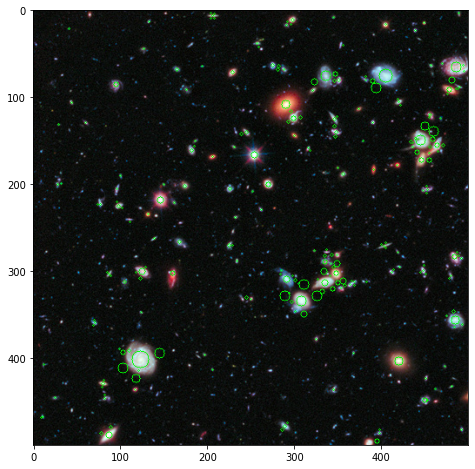

In [22]:
display_im = color_image.copy()
for i in range(len(refined_pois)):
  cv2.circle(display_im, (refined_pois[i][1], refined_pois[i][0]), radius=int(sigmas[0, refined_pois[i][2]]), color=(0, 255, 0), thickness=1)
plt.figure(figsize=(12, 8))
plt.imshow(display_im)

**We should see that the majority of the green circles have disappeared, and not we only have circles around some of the larger galaxies, and it seems to be capturing them well (assuming you did what I did). You'll see some extra circles near the edges of the galaxies, which we don't want, since these features aren't interesting (they are formed because of the black blobs).**

**Hence some more processing has to be done. But we won't do that here.**

**Instead, let's use some library functions like we always do.**

**Run the code below that I found in the scikit-image docs that shows a couple of ways we can do blob detection.**

/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


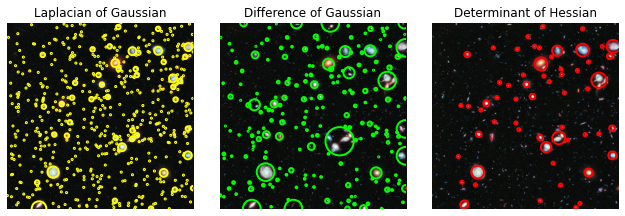

In [23]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()